<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB_week09_1_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ch4. 9~10 pg. 267-295

# **분류**

## **분류 실습 - 캐글 산탄데르 고객 만족 예측**

캐글의 산탄데르 고객 만족 데이터 세트에 대해 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해보자. 산탄데르 고객 만족 예측 분석은 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것이다. 산탄데르 은행이 캐글에 경연을 의뢰한 데이터로 피처 이름은 모두 익명처리되어 이름만을 가지고 어떤 속성인지는 추정할 수 없다. 클래스 레이블 명은 TARGET이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다.

모델의 성능평가는 TARGET이 불균형하므로 ROC-AIC로 평가하는 것이 적합하다.

### **데이터 전처리**

In [ ]:
!pip uninstall -y xgboost
!pip install xgboost==2.0.3  # 안정성과 호환성이 검증된 버전

Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Successfully uninstalled xgboost-2.0.3
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
cust_df =pd.read_csv('train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unstatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unstatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3 칼럼의 경우 min값이 -999999이다. NaN이나 특정 예외 값을 -999999로 변환했을 것이다. 따라서 -999999은 편차가 너무 심하므로 값이 가장 많은 2로 변환한다. ID 피처는 단순 식별자에 불과하므로 피처를 드롭한다.

In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


train data와 test data를 split한다. 이때, 비대칭한 데이터이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인한다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값으로 만들어졌다.

XGBoost의 early stopping의 검증 데이터 세트로 사용하기 위해 X_train, y_train을 다시 쪼개 학습과 검정 데이터 세트로 만든다.

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

### **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random_state는 예제 수행시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc',
            eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

test 데이터로 예측 시 ROC AUC는 약 0.8417이다

이제 HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝을 수행해보자.

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth': hp.quniform('max_depth',5,15,1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.2)}

다음으로 목적 함수를 만들어보자. 목적 함수는 3 fold 교차 검증을 이용해 평균 ROC-AUC 값을 반환하되 -1을 곱해 최소 반환값이 되도록 한다. 교차 검증 시 XGBoost의 조기 중단과 검증 데이터 성능 평가를 위해 KFold 클래스를 이용해 직접 학습과 검증 데이터 세트를 추출하고 이를 교차 검증 횟수만큼 학습과 성능 평가를 수행한다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth = int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          colsample_bytree = search_space['colsample_bytree'],
                          learning_rate = search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)

  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                eval_set =[(X_tr, y_tr),(X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 kfold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
  return -1 * np.mean(roc_auc_list)

이제 fmin() 함수를 호출해 max_eval=50회만큼 반복하며 최적의 하이퍼 파라미터를 도출해보자.

In [ ]:
from hyperopt import fmin, tpe, Trials
trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출

best = fmin(fn=objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals=50,
            trials = trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[38]	validation_0-auc:0.91468	validation_1-auc:0.83462
[39]	validation_0-auc:0.91515	validation_1-auc:0.83401
[40]	validation_0-auc:0.91526	validation_1-auc:0.83418
[41]	validation_0-auc:0.91540	validation_1-auc:0.83409
[42]	validation_0-auc:0.91609	validation_1-auc:0.83382
[43]	validation_0-auc:0.91642	validation_1-auc:0.83337
[44]	validation_0-auc:0.91755	validation_1-auc:0.83371
[0]	validation_0-auc:0.82893	validation_1-auc:0.79630
[1]	validation_0-auc:0.84185	validation_1-auc:0.81151
[2]	validation_0-auc:0.83892	validation_1-auc:0.81016
[3]	validation_0-auc:0.84844	validation_1-auc:0.81883
[4]	validation_0-auc:0.85049	validation_1-auc:0.82190
[5]	validation_0-auc:0.85235	validation_1-auc:0.82399
[6]	validation_0-auc:0.85587	validation_1-auc:0.82399
[7]	validation_0-auc:0.85787	validation_1-auc:0.82579
[8]	validation_0-auc:0.86054	validation_1-auc:0.82705
[9]	validation_0-auc:0.86040	validation_1-auc:0.82705
[10]	validation_0-auc:0.86323	validatio

튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내보자. xgboost 모듈의 plot_importance( ) 메서드를 이용한다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

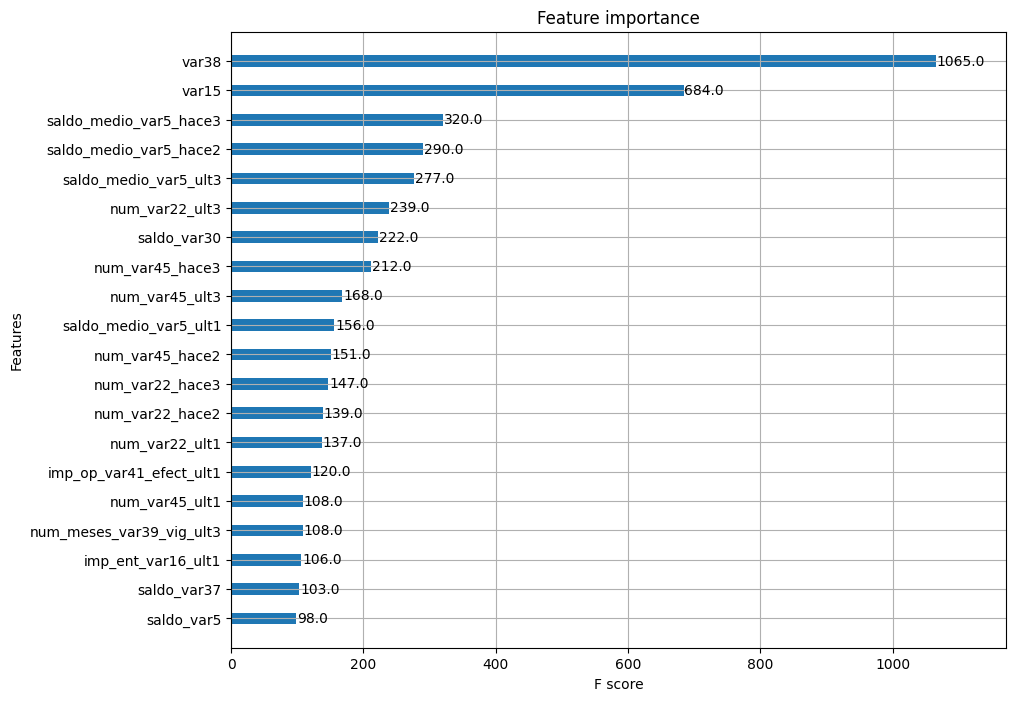

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순이다.

### **LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [ ]:
!pip uninstall -y lightgbm
!pip install lightgbm==4.1.0

Found existing installation: lightgbm 4.1.0
Uninstalling lightgbm-4.1.0:
  Successfully uninstalled lightgbm-4.1.0
  Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)


In [ ]:
import lightgbm
print(lightgbm.__version__)

4.1.0


In [ ]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)], eval_metric='auc',
             eval_set=eval_set)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.91059	training's binary_logloss: 0.112183	valid_1's auc: 0.831787	valid_1's binary_logloss: 0.13527
ROC AUC: 0.8384


In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves',32,64,1),
                     'max_depth':hp.quniform('max_depth',100,160,1),
                     'min_child_samples':hp.quniform('min_child_samples',60,100,1),
                     'subsample': hp.uniform('subsample',0.7,1),
                     'learning_rate': hp.uniform('learning_rate',0.01,0.2)}

이제 목적 함수를 생성해보자.

In [ ]:
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves = int(search_space['num_leaves']),
                          max_depth = int(search_space['max_depth']),
                          min_child_samples = int(search_space['min_child_samples']),
                          subsample = search_space['subsample'],
                          learning_rate = search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)

  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=30)], eval_metric="auc",
                eval_set =[(X_tr, y_tr),(X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 kfold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
  return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호추 . max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50,
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:',best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.88765	training's binary_logloss: 0.121808	valid_1's auc: 0.831519	valid_1's binary_logloss: 0.135868
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252416 seconds.
You can set `force_row_wise=true` 

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정 후 학습
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)],
             eval_metric='auc', eval_set=[(X_tr, y_tr),(X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.899119	training's binary_logloss: 0.11717	valid_1's auc: 0.833934	valid_1's binary_logloss: 0.13474
ROC AUC: 0.8417


## **분류 실습 - 캐글 신용카드 사기 검출**

해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다. 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다.

### **언더 샘플링과 오버 샘플링의 이해**
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 제대로 다양한 유형을 학습하지 못하고 정상 레이블을 가지는 데이터 건수는 매우 많아 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워져 예측 성능에 문제가 발생할 수 있다. 따라서, 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법을 통해 적절한 학습 데이터를 확보하며, 오버 샘플링 방식이 예측 성능상 족므 유리한 경우가 많아 상대적으로 더 많이 사용된다.

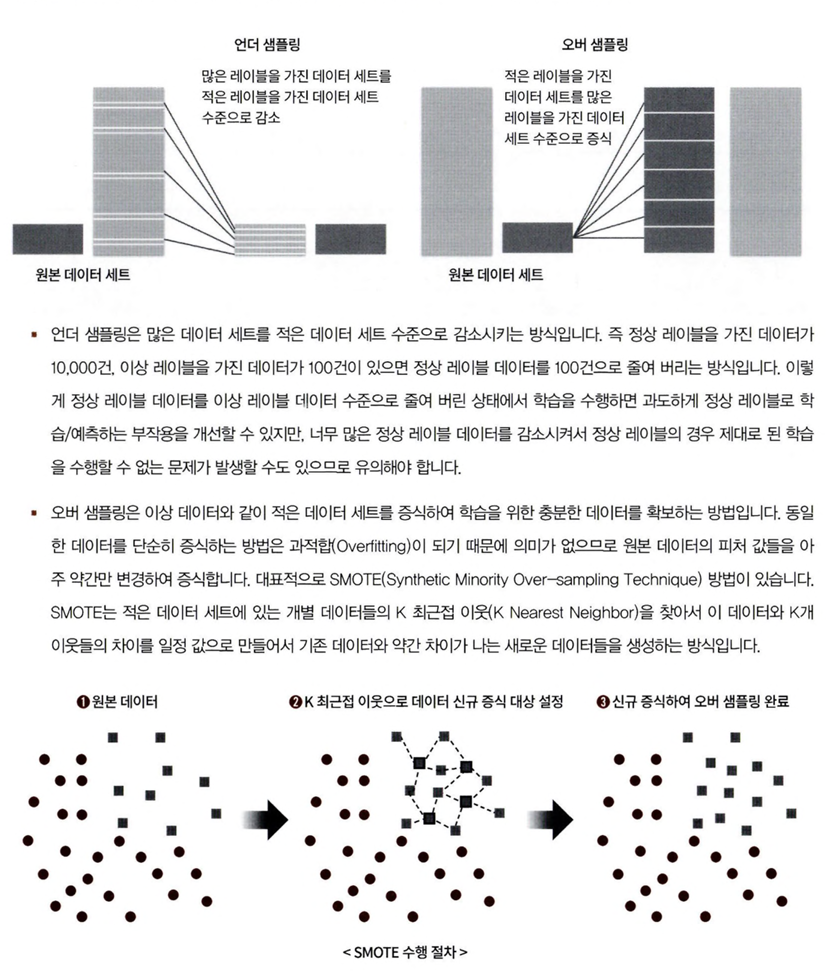

SMOTE를 구현한 대표적인 파이썬 패키지는 imbalanced-learn 이다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로 큰 의미가 없다. Amount피처는 신용카드 트랜잭션 금액을 의미하며 Class는 레이블로 0은 정상, 1은 사기 트랜잭션이다. card_df.info( )로 확인해보면 전체 284,807개의 레코드에서 결측치는 없으며 Class 레이블만 int형이고 나머지 피처들은 모두 float형이다.

보다 다양한 데이터 사전 가공과 예측 성능 비교를 위해 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df( ) 함수와 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df( ) 함수를 생성한다.

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,
                                                   test_size=0.3,random_state=0,stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


학습 데이터의 레이블과 테스트 데이터의 레이블에 큰 차이가 없이 잘 분할되었다. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴보자. 먼저 로지스틱회귀를 이용해 신용 카드 사기 여부를 예측해보자.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1： {3:.4f}, AUC：{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1： 0.7194, AUC：0.9741


테스트 데이터 세트로 측정시 재현율이 0.6216, ROC-AUC가 0.9702이다. 이번에는 LightGBM을 이용한 모델을 만들어보자. 반복적으로 모델을 변경해 학습/예측/평가하므로 이를 위한 별도의 함수를 생성한다.

In [ ]:
# 인자로 사이킷런의 Estimators 객체와 학습/테스트 데이터 세트를 입력받아 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

먼저 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average = False로 파라미터를 설정해야 한다.

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

재현율 0.7568, ROC-AUC 0.9790으로 앞의 로지스틱 회귀보다 높은 수치를 나타낸다.

### **데이터 분포도 변환 후 모델 학습/예측/평가**
이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해보자. 먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴본다. 로지스틱 회귀는 선형 모델이며, 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. Amout피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높으므로 Amout 피처의 분포도를 확인해보자.

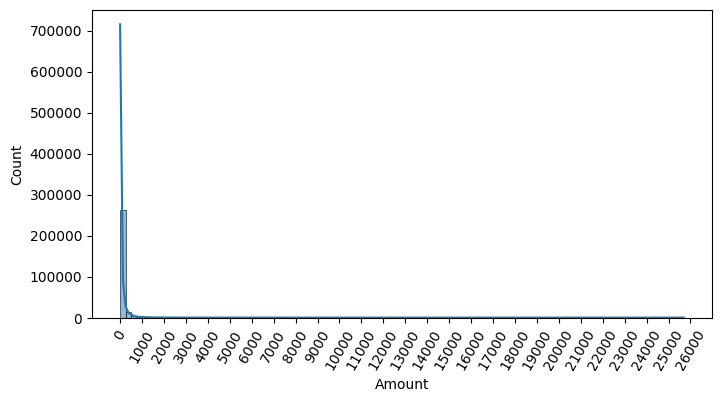

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

Amount가 1000불 이하인 데이터가 대부분이며, 26,000불까지 드물지만 많은 금액을 사용한 경우가 발생하며 꼬리가 긴 형태의 분포 곡선을 가지고 있다. Amout를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해보자.

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amout를 Amout_scale로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled', amount_n)
  # 기존 Time ,Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1, inplace=True)
  return df_copy

In [ ]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test ,tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1： 0.7294, AUC：0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

정규분포 형태로 Amout 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀는 정밀도와 재현율이 조금 저하되었고 LightGBM은 정밀도와 재현율이 저하되었지만 성능상의 큰 변화는 없었따.

이번에는 StandardScaler가 아니라 로그 변환을 수행한다. 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선한다. 로그 변환은 넘파이의 log1p( ) 함수를 이용해 간단히 변환이 가능하다.

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time'],axis=1,inplace=True)
  return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test ,tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8713, 재현율: 0.5946, F1： 0.7068, AUC：0.9761
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

### **이상치 데이터 제거 후 모델 학습/예측/평가**

이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 이상치를 찾는 방법은 여러가지가 있지만, 이중에서 IQR 방식을 적용한다. IQR은 사분위 값의 편차를 이용하는 기법으로 흔히 박스 플롯 방식으로 시각화할 수 있다.

먼저 사분위에 대해 알아보자.

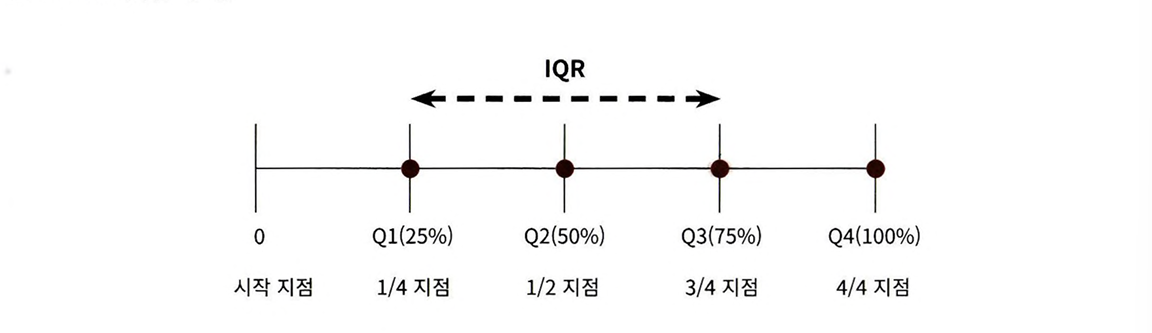

박스 플롯은 다음과 같은 표현 방식으로 사분위의 편차와 IQR, 그리고 이상치를 나타낸다.

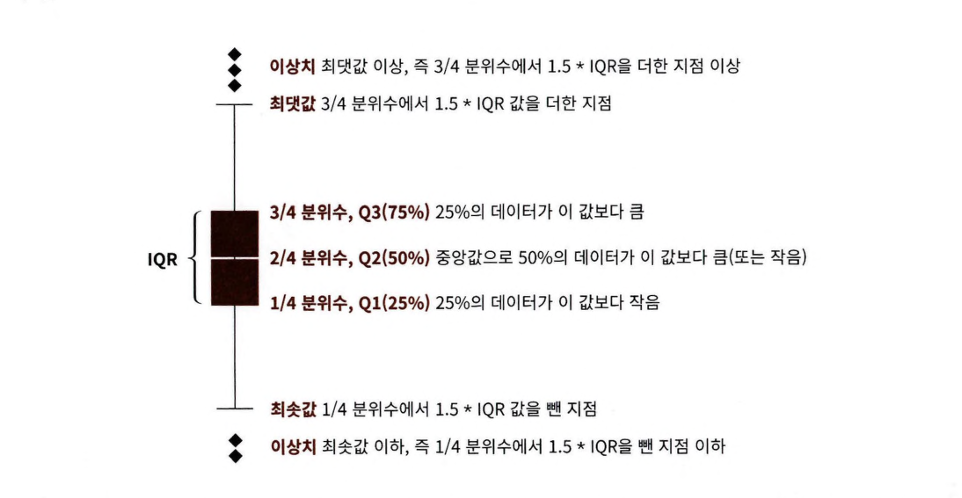

먼저 이상치 데이터를 IQR을 이용해 제거해보자. 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다. 매우 많은 피처가 있을 경우 이들 중 레이블과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다.

<Axes: >

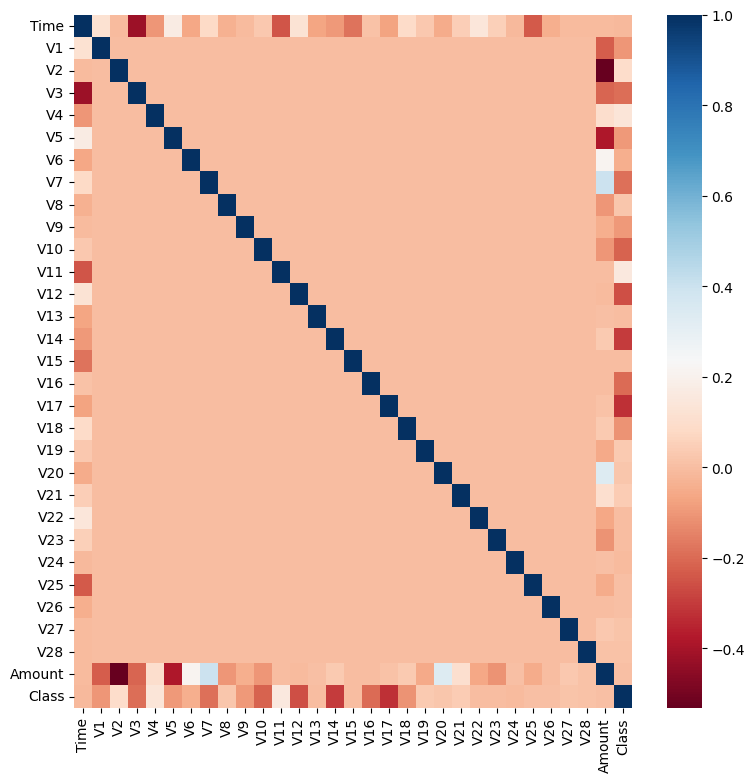

In [ ]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

히트맵에서 양의 상관관계가 높을 수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다. 상관관계 히트맵에서 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 이 중 V14에 대해서만 이상치를 찾아서 제거한다. IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제한다.

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values,25)
  quantile_75 = np.percentile(fraud.values,75)

  # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


get_outlier을 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 로지스틱 회귀와 LightGBM 모델을 적용한다.

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy = df_copy.drop(['Time','Amount'],axis=1, inplace=False)

  # 이상치 데이터 삭제
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('## 로지스틱 회귀 예측 성능 ##')
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)

print('## LightGBM 예측 성능 ##')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test=X_test, tgt_train=y_train, tgt_test = y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1： 0.7568, AUC：0.9725
## LightGBM 예측 성능 ##
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

### **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가한다. SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 한다.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 Class
0    199020
1    199020
Name: count, dtype: int64


SMOTE 적용 후 2배에 가깝게 데이터가 증식되었다.

In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train 과 tgt_train 인자값이 SMOTe 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train=y_train_over,
                     tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1： 0.1022, AUC：0.9736


로지스틱에 경우 재현율이 크게 증가하지만 정밀도가 급격히 저하된다. 원본 데이터의 유형보다 너무나 많은 class=1 데이터를 학습하며 실제 데이터 세트에서 예측을 지나치게 class=1로 지정해 정밀도가 떨어지게 된 것이다.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

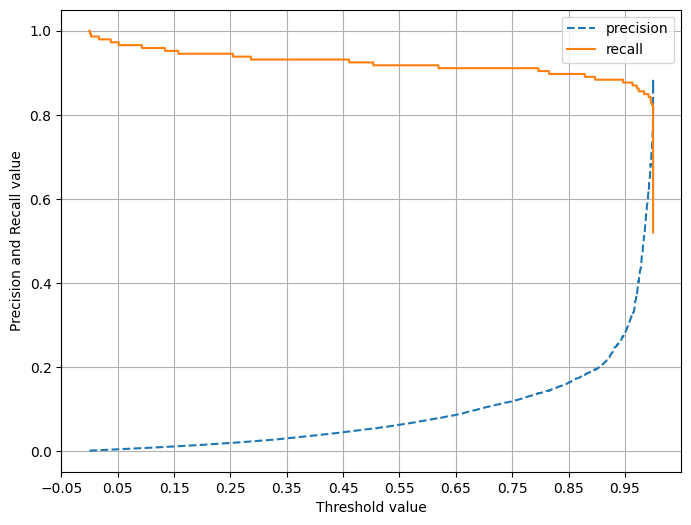

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값이 0.99이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서 재현율이 대폭 떨어지고 정밀도가 높아진다. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행해보자.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train=y_train_over,
                     tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

재현율은 높아졌지만 마찬가지로 정밀도는 낮아졌다. SMOTE를 적용하면 재현율은 높아지나 정밀도는 낮아지는 것이 일반적이다. 따라서, 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE를 적용하면 좋다.

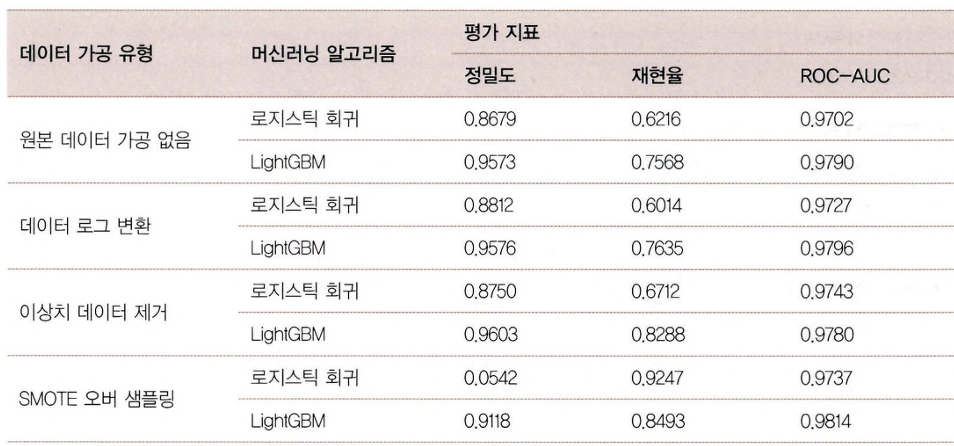